# State Farm Distracted Driver Detection

1.35 million people die in car accidents and most of the accidents happen because of drivers doing multiple tasks while driving. In other words, getting distracted. State Farm collected the data of several subjects in various situations(mentioned below) in a controlled environment.

#### Various Situations or class of images:
- c0: safe driving
- c1: texting - right
- c2: talking on the phone - right
- c3: texting - left
- c4: talking on the phone - left
- c5: operating the radio
- c6: drinking
- c7: reaching behind
- c8: hair and makeup
- c9: talking to passenger

## Business Understanding
State farm wants to make use of machine learning and deep learning techniques to predict the current state of the driver. We need to find the likelihood of what the driver is doing in each picture.  

## Data Description
- **imgs.zip** - zipped folder of all (train/test) images
- **sample_submission.csv** - a sample submission file in the correct format
- **driver_imgs_list.csv** - a list of training images, their subject (driver) id, and class id

## Data Processing
- We are making use of ImageDataGenerator from keras package to do image augmentation, performed below operations:
> - Shear image (0.2)
> - Zoomed image (0.2)
> - Horizontal flip
> - Vertical flip
- We also used openCV for some minor image processing such as zooming in on drivers and resizing the image to 224x224.
- **Splitting of data:** Previously data was split randomly into test and train however after looking into the data we realized that same person's images were in both test and train sets with very slight variation in the images. Hence, there were chances of overfitting. So, we took different approach where splitting was done based on subject. We used images of "p045", "p075", "p022", and "p012" subjects as test images and rest as train images.
- For traditional machine learning algorithm (random forest) we extracted features from the images and stored them in a data set. Following at the features extracted from the images:
> - Pixel values: Pixel vales were stored as on of the features.
> - Gabor filter: Gabor filter was used to analyze the texture of the images, it helps us to examine patterns in some particular direction. For example, presence of human subject in the image. Below is the mathematical equation of Gabor filter. <br>
$g(x, y; {\lambda}, \theta, \psi, \sigma, \gamma) = \exp\left(-\frac{x'^2+\gamma^2y'^2}{2\sigma^2}\right)\cos\left(2\pi\frac{x'}{\lambda}+\psi\right)$ <br>
where: <br>
>> - $ {\displaystyle x'=x\cos \theta +y\sin \theta} and {\displaystyle y'=-x\sin \theta +y\cos \theta }.$
>> - $ \lambda $   represents the wavelength.
>> - $ \theta $ represents the orientation.
>> - $ \psi $  is the phase offset .
>> - $ \sigma $  is the sigma/standard deviation.
>> - $ \gamma $ is the aspect ratio.
> - Sobel filter: Sobel filter was used for edge detection. It is a matrix with certain values which upon convolution with the image pixel matrix highlights the edges present in the picture. Below are vertical and horizontal sobal filters. 
${\displaystyle \mathbf {G} _{x}={\begin{bmatrix}+1&0&-1\\+2&0&-2\\+1&0&-1\end{bmatrix}}*\mathbf {A} \quad {\mbox{and}}\quad \mathbf {G} _{y}={\begin{bmatrix}+1&+2&+1\\0&0&0\\-1&-2&-1\end{bmatrix}}*\mathbf {A} }$<br>
where:
>> - \* is the convolution operation.
>> - A is the original image.
>> - ${G}_{x}$ is the image with horizontal edges.
>> - ${G}_{y}$ is the image with vertical edges.<br>
> - Final resultant image can be obtained by below equation:
$\mathbf {G} ={\sqrt {{\mathbf {G} _{x}}^{2}+{\mathbf {G} _{y}}^{2}}}$



In [1]:
# importing relevant packages...
import os
import cv2
import glob
import random
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm
import tensorflow as tf
from skimage import color
from sklearn import metrics
from keras import backend as k
import matplotlib.pyplot as plt
from skimage.filters import sobel
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model, load_model

In [29]:
pd.set_option('display.float_format', lambda x: '%0.4f' % x) # limiting decimal numbers to 4 decimal places...

## Exploratory Data Analysis

In [5]:
img_count_list = [] # placeholder for image count of each classes...
for i in range(10): # 10 class of images...
    imgs = os.listdir("../data/imgs/train/c"+str(i)) # storing all the files from this directory path...
    img_count_list.append(len(imgs)) # calculating the number of images and storing it in the list...
    
img_count_class = { "safe driving": 2489,
"texting - right": 2267,
"talking on the phone - right": 2317,
"texting - left": 2346,
"talking on the phone - left": 2326,
"operating the radio": 2312,
"drinking": 2325,
"reaching behind": 2002,
"hair and makeup": 1911,
"talking to passenger": 2129 } # dictionary of class name as keys and count of images as values...

# making dataframe from the dictionary we got in the previous step...
count_df = pd.DataFrame(list(img_count_class.items()),columns = ['Class','Count']) 

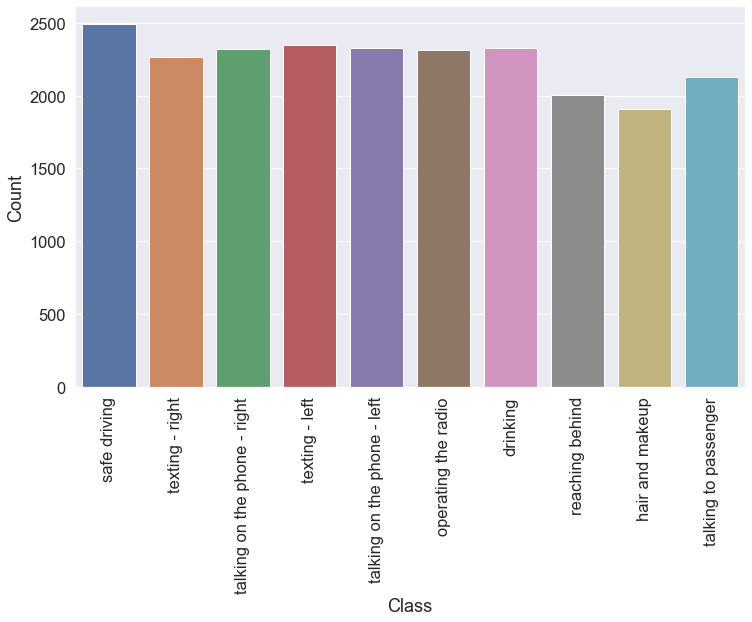

In [49]:
# Plot of number of images each class has... 
fig, ax = plt.subplots(figsize=(12, 7)) # Figure size...
ax = sns.barplot(data = count_df, x = 'Class', y = 'Count')
sns.set(font_scale = 1.5)
ax.set_xticklabels(ax.get_xticklabels(),rotation = 90)
plt.show()

From the above plot we can see that on an average all the classes have around 2000 images. Hence, the dataset is balanced.

In [6]:
# loading the csv file that contains, subject id, class name and image name...
person_df = pd.read_csv('../data/driver_imgs_list.csv')

# calculating number of images of each subject...
person_count_df = pd.DataFrame(person_df['subject'].value_counts())

person_count_df.reset_index(inplace=True) # Resetting the index of the dataframe...
person_count_df.columns = ['subject', 'count'] # changing the column name...

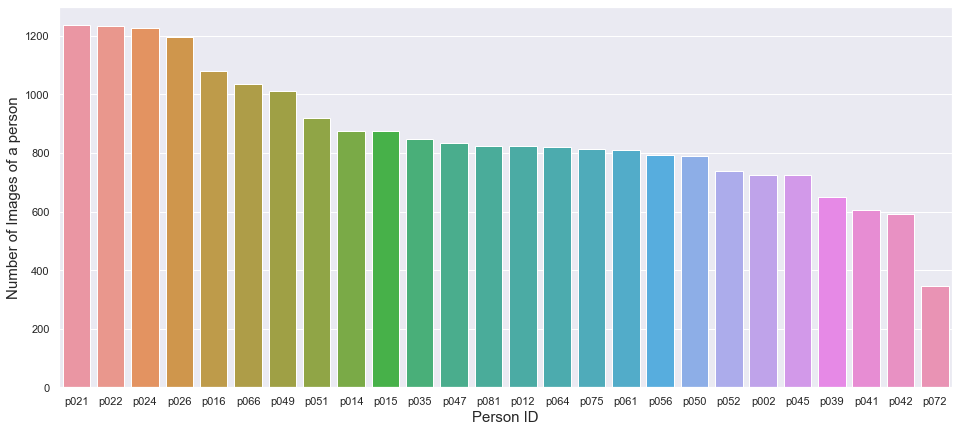

In [69]:
# Plot of number of images of each subject...
fig, ax = plt.subplots(figsize=(16, 7)) # Figure size...
ax = sns.barplot(data = person_count_df, x = 'subject', y = 'count')
sns.set(font_scale = 1) # setting font size of the text in the plot...
plt.xlabel('Person ID', fontsize = 15)
plt.ylabel('Number of Images of a person', fontsize = 15)
plt.show()

From the above plot we can see some subjects have significantly more images than others. However this will not affect our model and results as we are dividing our dataset based on subjects, i.e., keeping "p045", "p075", "p022", and "p012" in test and rest in train set.

## Modeling and Model Evaluation

#### NOTE: For core modelling code refer ./src/modelling/model.py

In [2]:
# function to perform minor image processing and make prediction...
# img_path: path of image needs to be classified...
# model: model that needs to be used to make prediction...
def classify_driver(img_path, model): 
    img = cv2.imread(img_path) # Reading img...
    #img = color.rgb2gray(img) # RGB to Grayscale...

    # Zooming in on the dirver...
    img = img[50:, 100:-50]
    
    # Resizing the img to 224x224...
    img = cv2.resize(img, (224, 224)) 
    
    # converting img data to array...
    img_array = image.img_to_array(img) 
    
    # reshaping to have 3 channels and making prediction...
    img_array = np.array(img_array).reshape(-1,224,224,3) 
    prediction = model.predict(img_array)
    
    # returning the probability values of each class(prediction) and processed image(img)...
    return prediction, img 

In [3]:
# function to pass each img path at a time to classify_driver() function... 
# model: model that needs to be used to make prediction...
def make_pred(model):
    predictions = [] # list to store all the predictions...
    test_imgs = [] # list to store all the images that are being tested...
    
    # iterating over each image...
    for filepath in tqdm(glob.iglob('../data/imgs/small_test/*.jpg')): 
        
        # calling classify_driver() with img file path and model that needs to be used...
        row, img = classify_driver(filepath, model)
        
        # storing img that was tested...
        test_imgs.append(img)
        
        # splitting the filepath on '\' and selecting the last element i.e., img name...
        file_name = filepath.split("\\")[-1] 
        
        # storing all the predictions row wise...
        row = list(row[0])
        row.insert(0, file_name)
        predictions.append(row)
    
    # returning the probability value of each class for all the images (predictions) and the img...
    return predictions, test_imgs 

In [4]:
# dictionary of class labels as keys and their meaning as values...
class_desc = { "C0": "safe driving",
"C1": "texting - right",
"C2": "talking on the phone - right",
"C3": "texting - left",
"C4": "talking on the phone - left",
"C5": "operating the radio",
"C6": "drinking",
"C7": "reaching behind",
"C8": "hair and makeup",
"C9": "talking to passenger" }

In [6]:
# Function to display images and their class names...
# predictions: the probability value of each class for all the images...
def image_grid(predictions): 
    fig, ax = plt.subplots(4,5, figsize = (100,100)) # grid of 4x5 and plot size 100x100...
    count1 = count2 = 0 # count1: row iterator, count2: column iterator...
    for i in range(20): # testing 20 images...
        
        # if i is divisible by number of columns(5), increase the rows index and make the column iterator 0...
        # traversing left to right then top to bottom... (0,0 > 0,1 > 0,2 > ... > 3,2 > 3,3 > 3,4)
        if i%5 == 0 and i != 0:
            count1 += 1
            count2 = 0
            
        # displaying the image in a particular block of the grid...
        ax[count1, count2].imshow(test_imgs[i])
        
        # fnding class name from probabilities... maximum probability is the class of the image...
        predicted_class = 'C'+str(np.where(predictions[i][1:] == np.amax(predictions[i][1:]))[0][0])
        
        # setting the predicted class as the title...
        ax[count1, count2].set_title(class_desc[predicted_class], size=80)

        # hiding the x and y ticks...
        ax[count1, count2].axis("off")
        
        # increasing the column iterator...
        count2 += 1
    plt.show() # displaying the whole grid...

### Traditional Machine Learning Algorithm (Random Forest)

#### Why Traditional Machine Learning when CNNs are preferred on image data?
- CNNs work very well when there are tons of data. In our case we have 10 classes and only 2000 images on an average per class. So, we wanted to compare traditional machine learning algorithm's performance with CNN. However, feature extraction was taking extended period of time so, we end up using only 4000 images out of 18000 test images.

#### Why Random Forest?
- Random forest can implicitly carry out feature selection which makes it one of the better options when there are lots of features. It builds different decision trees by randomly selecting the subset of features.
- There is less to no effect of outliers on random forest. There are chances some of the images might have dirty pixels or while processing them we have introduced some errors. So, it will be taken care by binning of variables in Random Forest.
- Random forest can handle bias-variance trade-off well as it makes multiple decision trees and then takes average of all the trees, hence, averages the variance too.

#### Why Gabor Filter as feature?
- Gabor filter does a very good job in picking out loose edges present in the images. So, by applying gabor filter we will be able to extract the features like where the hands are, what might be the face orientation etc. For detailed explanation of gabor filter equation refer Data Processing Section above in this notebook.

#### Why Sobel Filter as feature?
- Sobel filters are mainly used for edge detection. In our case when edge detected by sobel is combined with gabor filter we can expect them to work well in detecting the hand, head and body position so that the right state of the driver can be predicted. For detailed explanation of the equation refer Data Processing Section above in this notebook.

In [32]:
# Function to extract features from the image dataset...
# dataset: images from which features need to be extracted...
def feature_extractor(dataset):
    
    # placeholder for final features... (final dataset)
    image_dataset = pd.DataFrame() 
    
    # iterating over all the images...
    for i in tqdm(range(np.array(dataset).shape[0])):  
        feat_df = pd.DataFrame()  # placeholder for features of one image...
        input_img = np.array(dataset)[i, :,:,:] # i = image index, all image rows, all image cols, all the channels...
        pix_val = input_img.reshape(-1) # making the 2 dimentional img to 1 dimentonal
        feat_df['Pixel_Value'] = pix_val  # storing them in a feat_df dataframe under column name 'Pixel_value'
        counter = 1 # gabor counter...
        kernels = [] # placeholder for calculated filter values...
        for theta in range(2): # using 3 different values of theta...  
            theta = theta / 4. * np.pi
            for sigma in (1, 3):  # using 2 values of sigma...
                lamda = np.pi/4 
                gamma = 0.5
                gabor_label = 'Gabor' + str(counter) # column name as "Gabor1" , "Gabor2" and so on...
                
                # calculating kernel values based on sigma, theta, lambda, gama, and shape of kernel (9,9)...
                # CV_32FC2 is a 32-bit, floating-point, and 2-channels structure...
                kernel = cv2.getGaborKernel((9, 9), sigma, theta, lamda, gamma, 0, ktype=cv2.CV_32F)   
                
                kernels.append(kernel) # storing the kernel/filter values...
                
                # Applying the gabor filter on to the image calculated in the previous step...
                # CV_8UC3 is an 8-bit unsigned integer matrix(2D)/image with 3 channels...
                fimg = cv2.filter2D(input_img, cv2.CV_8UC3, kernel) 
                fimg = fimg.reshape(-1) # reshaping it to 1D...
                feat_df[gabor_label] = fimg # adding to data frame...
                counter += 1  
                
        # applying sobel filter for edge detectection...
        edge_sobel = sobel(input_img)
        edge_sobel1 = edge_sobel.reshape(-1)
        feat_df['Sobel'] = edge_sobel1
        image_dataset = image_dataset.append(feat_df)
        
    # returning dataset with 3 type of features, 1: pixel values, 2: gabor filter, 3: sobel edge detector...
    return image_dataset 

In [8]:
# loading model(traditional machine learning model), and test data...
model = pd.read_pickle("../models/model/model")
X_test = pd.read_pickle("../data/X_test.txt")
y_test =  pd.read_pickle("../data/y_test.txt")

In [25]:
# extracting feature from the test image dataset...
test_img_features = feature_extractor(X_test)

# making the feature dataset suitable for random forest model...
test_img_features = np.expand_dims(test_img_features, axis=0)
X_test_RF = np.reshape(test_img_features, (np.array(X_test).shape[0], -1))

pred = model.predict(X_test_RF) # making prediction...
pred = pred.argmax(axis = -1) # getting class labels from probability values...

print (f"Accuracy of Traditional machine learning approach on very limited data points is: \
{format(metrics.accuracy_score(y_test, pred)*100, '.2f')}%")

Accuracy of Traditional machine learning approach on very limited data points is: 13.20%


From above result we can see we only managed to get 13.20% of accuracy, however, we only considered 22% of data points i.e., 4000 images out of around 18000 images. So, definitely model can be improved to a greater extent when more images are used. That can be tried in the future, for now to reduce the computation overhead we are only considering 4000 images for traditional machine learning model.

### CNN Trained from Scratch (VGG16 architecture)

#### Why CNNs are good for image data?
- CNNs are fully connected feed forward neural networks.
- In deep neural networks usually there are lots of parameters to be tuned which can be very computation intensive and take considerable amount of time. That time can be reduced with CNNs.
- CNNs are good with large number of features and in images we have many features as each pixel is considered as a feature. CNNs make use of kernels or filters for dimensionality reduction. Sliding operation is performed using kernels and convolution operation is done this reduces the size of the image without losing much useful information hence, dimension reduced.

#### Why VGG16 Architecture?
- We have around 2000 images per class which is not a lot of data to properly train a very deep network and if we train a very shallow network it will not be able to pick up important features from the image and hence will perform poorly. VGG16 has 16 layers, it's not at all shallow at the same time it's not too deep, which suits our requirement. Below is the architecture of VGG16. (image source: https://neurohive.io/en/popular-networks/vgg16/)
![VGG16 Architecture](../plots/vgg16.png)

In [ ]:
# loading the model, making prediction, and storing the probabilities of each classes of all the images as a datafram...
model1 = load_model("../models/model1/model1.h5")
predictions1, test_imgs = make_pred(model1)
pred_df1 = pd.DataFrame (predictions1, columns = ['img', 'c0', 'c1', 'c2','c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9'])

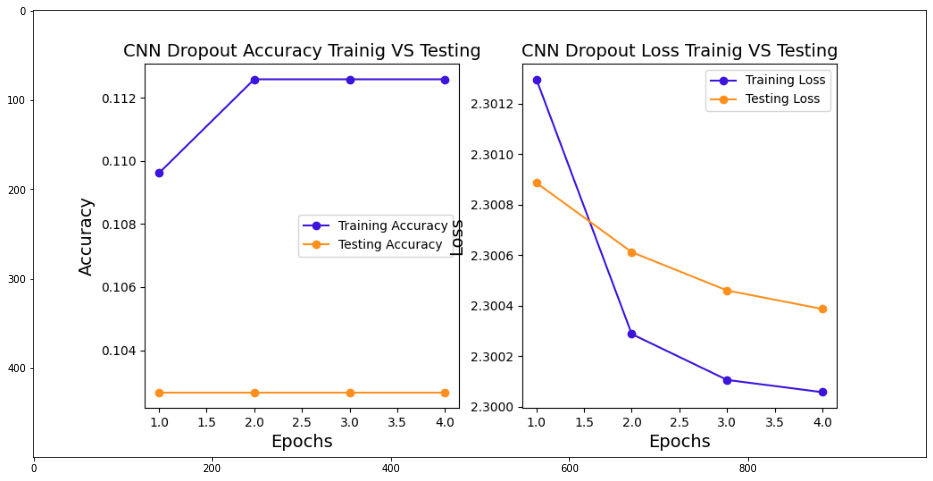

In [13]:
# plotting train and validation loss and accuracy for cnn model that was trained from scratch...
# NOTE: These plots where generated in src/modelling/model.py file and saved as .png so that can be included in this notebook...
fig, ax = plt.subplots(figsize=(16, 10)) # Figure size...
scratch_model = cv2.imread('../plots/from_scratch.png')
plt.imshow(scratch_model)

From above accuracy and loss plot we can observe following points:
- Training accuracy is increasing but not by much. We are only achieving 11% accuracy, whereas, test accuracy is not improving at all. 
- Training and testing loss is reducing but again not by much and loss is still high at the end of 4th epoch.
- Model is clearly underfit because it is performing poorly on both train as well as test set. We tried to improve it by increasing the complexity of the network by adding more filters, by adding more nodes, by increasing the number of epochs, by reducing the learning rate, with and without Dropout layers. Also tried various optimizers like adam, rmsprop, sgd, adagrad and activation functions like relu, elu, tanh, etc., but nothing seemed to be working so, we decided to move towards transfer learning using VGG16 pre-trained model, discussed next.

### CNN Trained using Transfer Learning (VGG16 Pretrained Model)

#### Why transfer learning?
- As we saw previously, when we are training our network from scratch it is underfitting even after increasing the complexity of the network. So, we decided to try transfer learning because rather than assigning random weights to start with we are using weights from VGG16 pre-trained model and expecting it to work better as it will have prior knowledge(weights from imagenet dataset). This also helps in faster training of model as weights are not assigned randomly. 
- VGG16  is a convolutional neural network model that was trained on imagenet dataset which contains around 14 million images belonging to 1000 classes. This model achieved around 95% accuracy on imagenet dataset. It a step forward on AlexNet model. AlexNet's Larger kernels were replaced by smaller 3x3 kernel in VGG16 and was trained on NVIDIA Titan GPUs for weeks.
- In addition to VGG16 pre-trained layers we added below layers:

| Layer (type)         |      Output Shape       |       Param |
| --- | --- | --- |
| img_input (InputLayer)   |   [(None, 224, 224, 3)]  |   0 |
| vgg16 (Functional)        |  (None, 7, 7, 512)      |   14714688|
| conv2d_13 (Conv2D)        |  (None, 5, 5, 128)   |      589952|
| global_average_pooling2d (G  (None, 128)     |         0|
| lobalAveragePooling2D)|
| dense_3 (Dense)            | (None, 1024)    |          132096|
| dropout (Dropout)          | (None, 1024)     |         0|
| dense_4 (Dense)             |(None, 512)      |         524800|
| batch_normalization (BatchN  (None, 512)     |         2048|
| ormalization)|
| dropout_1 (Dropout)        | (None, 512)       |        0|
| dense_5 (Dense)             |(None, 512)       |        262656|
| dense_6 (Dense)            | (None, 10)        |        5130|
________________________________________________________________
Total params: 16,231,370
Trainable params: 1,515,658
Non-trainable params: 14,715,712

#### Why ReLU activation function?
- ReLU stands for Rectified Linear Unit, following is the equation of ReLU. <br>
${\displaystyle f(x)=x^{+}=\max(0,x)}$ <br>
where, x is the input to a neuron. <br>
ReLU started getting popularity for feature extraction of image data and is argued to show biological motivation and also mathematically justified, because of these reasons ReLU is most widely used activation function in deep neural networks. 

#### Why He Initialization?
- He initialization is good for activation functions like ReLU which are non-linear.

#### Why valid padding?
- Valid padding is used because pixels at the boundary are getting only one convolution operation with kernel hence, not much information can be extracted from them plus when we use lot of filters, chances are image will reduce so much that we will lose most of the information. To avoid this problem we are using zero padding (valid padding).

#### Why GlobalAveragePooling2D?
- In GlobalAveragePooling2D the pool size is set to the input size and it outputs the average of the pool. It is closely related to convolution structure. It makes close links between feature map and categories. 

#### Why Dropout layer?
- Dropout layer helps in avoiding overfitting of model by deactivating some of the neurons to nullify their effect on decision making.

#### Why BatchNormalization?
- In neural network operation performed on the data is done in batches. So, normalization of data is done batch wise. It helps the model to avoid overfitting. 

#### Why Stochastic Gradient Descent (SGD) optimizer?
- Earlier preferred optimizer was Adam as it uses adaptive learning rate where as normal SGD keeps the same learning rate through out. However, while training it was observed that Adam was shooting very fast and model was overfitting. Hence, SGD was preferred to avoid overfitting. 

#### Other important terms:
- **categorical_crossentropy:** As it is a multiclass classification problem we are using loss as categorical_crossentropy. It is the measure of error which the model would want to minimize. 
- **accuracy:** As a performance evaluation metric, accuracy is being used. It is very interpretable and hence easy to compare multiple models especially when comparing machine learning and deep learning models.

In [ ]:
# loading the model, making prediction, and storing the probabilities of each classes of all the images as a datafram...
model2 = load_model("../models/model2/with_conv.h5")
predictions2, test_imgs = make_pred(model2)
pred_df12= pd.DataFrame (predictions2, columns = ['img', 'c0', 'c1', 'c2','c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9'])

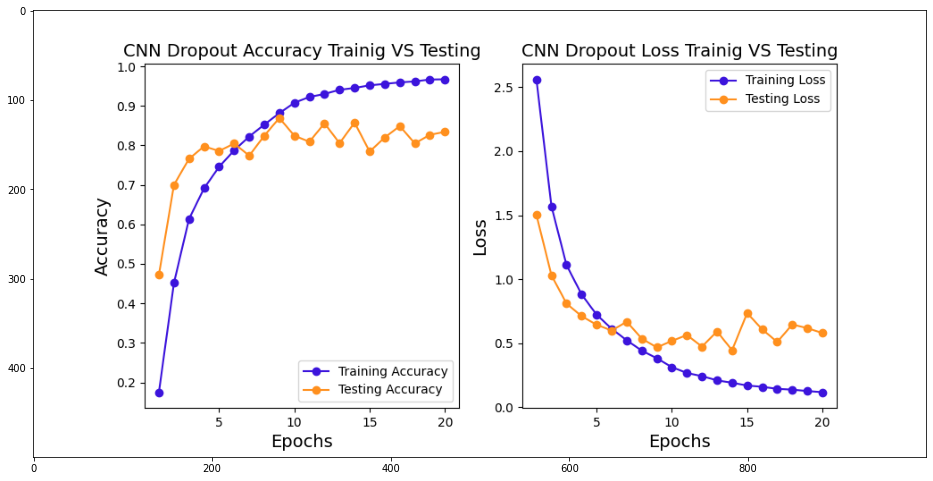

In [12]:
# plotting train and validation loss and accuracy 
# for cnn model that was trained using transfer learning vgg16 pre-trained model...
# NOTE: These plots where generated in src/modelling/model.py file and saved as .png so that can be included in this notebook...
fig, ax = plt.subplots(figsize=(16, 10)) # Figure size...
scratch_model = cv2.imread('../plots/with_conv.png')
plt.imshow(scratch_model)

From above plot we can infer below results:
- Training accuracy is 95% whereas test accuracy is 80%.
- Training loss is 0.1 where as test loss is 0.5.
- Clearly we can see that, this model is working very good as compared to other models we tested before. So, this model will be our final model and we will further test this model on test images that are provided separately in the test directory.

### Final model tested on test images
- 20 images randomly selected from the test folder that has over 70K images. These 20 images are stored in ./data/imgs/small_test directory.

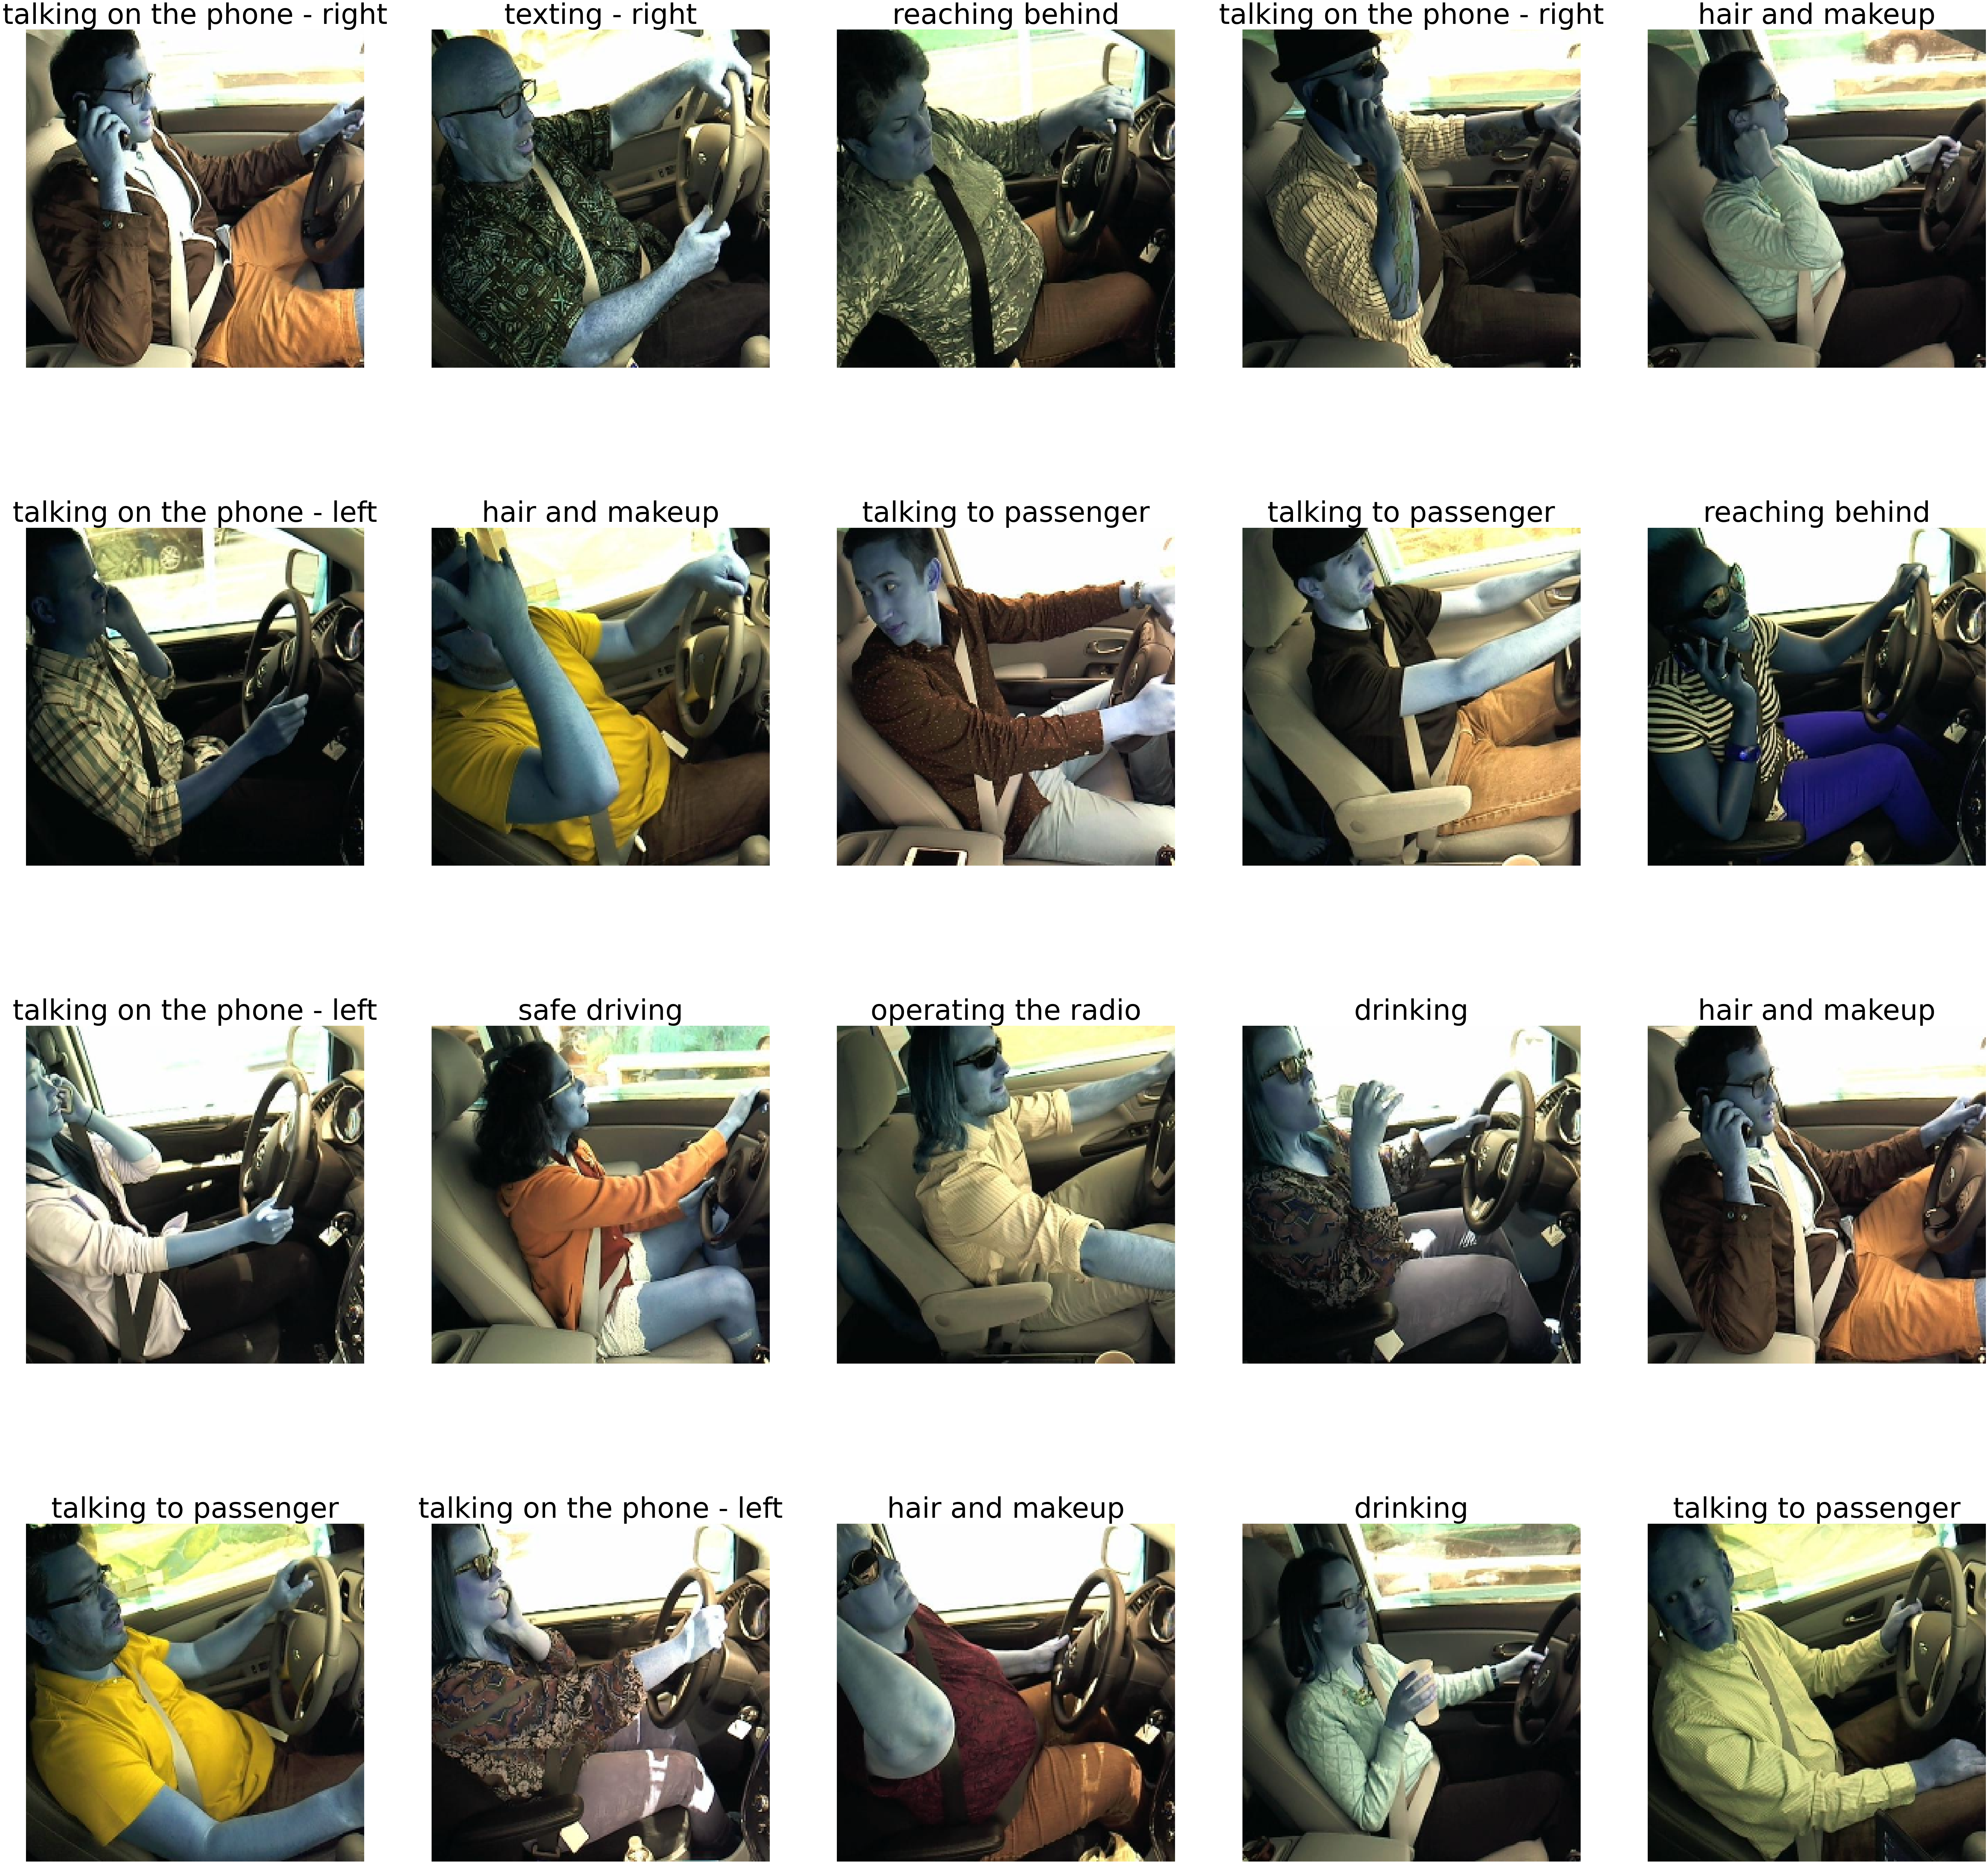

In [18]:
image_grid(predictions2) # calling image_grid function to make the below image grid along with their predictions..

NOTE: Color of the image is looking odd because openCV default color channel sequence is BGR rather than RGB.

From above grid we can see that most of the images are correctly classified(15). There are some misclassifications(5) that can be improved in the future models. 

## Conclusion and Future Scope

|S.No. | Model | Accuracy |
| --- | --- | --- |
| 1 | Traditional ML Algorithm (Random Forest) | 13% |
| 2 | CNN VGG16 Architecture from Scratch | 11% |
| 3 | CNN Transfer Learning (VGG16 Pre-Trained Model) | 80% |

From above table following key points can be inferred:
- CNN with transfer learning using VGG16 pre-trained model is performing the best as our model could use adjusted weights from the final layers of VGG16 pre-trained model which gave good learning starting point.
- CNN model trained from scratch performed the worst because it was underfitting this can be improved by making more complex model and trying different sizes of kernel. 
- Random forest model can be improved to a greater extent by using all the images for feature extraction. 
- Ensemble technique can also be used such as, using deep neural network for feature extraction and then applying traditional machine learning algorithm on top of it. 

## References
- [Sobel Filter](https://en.wikipedia.org/wiki/Sobel_operator)
- [Gabor Filter](https://en.wikipedia.org/wiki/Gabor_filter)
- [Handling of Overfitting in CNN](https://towardsdatascience.com/deep-learning-3-more-on-cnns-handling-overfitting-2bd5d99abe5d)
- [Handle overfitting and Underfitting](https://towardsdatascience.com/overfitting-vs-underfitting-a-complete-example-d05dd7e19765)